### This notebook takes the prepared data and carries out the selected modelling techniques.

In this notebook, the fake data will be used in the model to show that it is running properly. Please note that the results should not be used to assess the performance of the model since the data is completely fake.

In [44]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
from models.tree_forest import train_random_forest_model, train_decision_tree_model, loop_random_forest_model, loop_decision_tree_model
from visualisation.__init__ import make_feature_importance_table, make_handover_times_results_table, make_handover_delay_results_table


Getting the fake data for `3`, `10`, and `24` hours:

In [16]:
fake_data_3_hour = pd.read_parquet("../outputs/data_for_three_hour_pred.parquet")
fake_data_10_hour = pd.read_parquet("../outputs/data_for_ten_hour_pred.parquet")
fake_data_24_hour = pd.read_parquet("../outputs/data_for_twenty_four_hour_pred.parquet")

The columns within the fake datasets are as follows:

- Time
- Hospital name
- No. of A skills that are missing from ambulance arrivals in the last 6 hours
- No. of B skills that are missing from ambulance arrivals in the last 6 hours
- No. of C skills that are missing from ambulance arrivals in the last 6 hours
- No. of D skills that are missing from ambulance arrivals in the last 6 hours
- No. of E skills that are missing from ambulance arrivals in the last 6 hours
- No. of ambulance arriving in the last 6 hours
- No. of ambulance depatures in the last 6 hours
- Proxy for net flow (admissions, discharges, transfers)
- The average time of past delays (minutes) in the last 6 hours per hospital
- The weighted sum by distance of the number of ambulances arriving at other hospitals
- No. of people arriving in the last 6 hours that are aged less than 1
- No. of people arriving in the last 6 hours that are aged between 1 and 18
- No. of people arriving in the last 6 hours that are aged between 19 and 36
- No. of people arriving in the last 6 hours that are aged between 37 and 54
- No. of people arriving in the last 6 hours that are aged between 55 and 72
- No. of people arriving in the last 6 hours that are aged between 73 and 90
- No. of people arriving in the last 6 hours that are aged above 90
- No. of people arriving in the last 6 hours that are responding priority 1
- No. of people arriving in the last 6 hours that are responding priority 2
- No. of people arriving in the last 6 hours that are responding priority 3
- No. of people arriving in the last 6 hours that are responding priority 4
- No. of people arriving in the last 6 hours that are responding priority 5
- No. of people arriving in the last 6 hours that are responding priority 6
- No. of people arriving in the last 6 hours that are responding priority 7
- No. of people arriving in the last 6 hours that are responding priority 8
- No. of people arriving in the last 6 hours that are responding priority 9
- No. of ambulances arriving in the last 6 hour that have transported 1 patient
- No. of ambulances arriving in the last 6 hour that have transported 2 patient
- No. of ambulances arriving in the last 6 hour that have transported 3 patient
- Day of week
- Month
- Hour of day
- Bank holiday
- Max temperature 
- Min temperature
- Rainfall (mm)

Make a `dict` with the hours and their corresponding fake datasets:

In [17]:
fake_datasets_dict = {'3': fake_data_3_hour,
                      '10': fake_data_10_hour,
                      '24': fake_data_24_hour}

Initialising the list of fake hospitals:

In [18]:
list_of_fake_hospitals = ['hospital_A', 
                          'hospital_B',
                          'hospital_C',
                          'hospital_D',
                          'hospital_E']

Initialising the `FAKE_ORDINALS` and `FAKE_REALS`:

In [19]:
TARGET = ['handover_delay_mins']

FAKE_ORDINALS = {'day_of_week': ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                 'hour_of_day': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                 'bank_holiday': ['No', 'Yes']}

FAKE_REALS = ['missing_skill_A', 'missing_skill_B', 'missing_skill_C', 'missing_skill_D', 'missing_skill_E', 
              'num_ambulance_arrivals', 'num_ambulance_departures',
              'flow', 
              'past_delay_mins', 
              'weighted_arrivals_other', 
              '1 to 18', '19 to 36', '37 to 54', '55 to 72', '73 to 90', '90+', '<1', 
              'priority_1', 'priority_2', 'priority_3', 'priority_4', 'priority_5', 'priority_6', 'priority_7', 'priority_8', 'priority_9', 
              '1_patient_transported', '2_patients_transported', '3_patients_transported', 
              'tmax', 'tmin', 'rain']

Setting the variable names to more meaningful names to output in the feature importance table.

In [21]:
keyword_to_english_map = {'hospital': 'Hospital',
                          'day_of_week': 'Day of Week',
                          'month': 'Month',
                          'hour_of_day': 'Hour of the Day',
                          'bank_holiday': 'Bank Holiday',
                          'missing_skill_A': 'Missing Crew Skill',
                          'missing_skill_B': 'Missing Crew Skill',
                          'missing_skill_C': 'Missing Crew Skill',
                          'missing_skill_D': 'Missing Crew Skill',
                          'missing_skill_E': 'Missing Crew Skill',
                          'num_ambulance_arrivals': 'Number of Ambulance Arrivals',
                          'num_ambulance_departures': 'Number of Ambulance Departures',
                          'flow': 'Patient Flow',  
                          'past_delay_mins': 'Average Handover Delay in Past 6 Hours',
                          'weighted_arrivals_other': 'Arrivals at Hospitals Nearby',
                          '1 to 18': "Number of 1 to 18 Year Old's Arriving",
                          '19 to 36': "Number of 19 to 36 Year Old's Arriving",
                          '37 to 54': "Number of 37 to 54 Year Old's Arriving",
                          '55 to 72': "Number of 55 to 72 Year Old's Arriving",
                          '73 to 90': "Number of 73 to 90 Year Old's Arriving",
                          '90+': "Number of 90+ Year Old's Arriving",
                          '<1': "Number of <1 Year Old's Arriving",
                          'priority_1': 'Number of Priority 1 Cases',
                          'priority_2': 'Number of Priority 2 Cases',
                          'priority_3': 'Number of Priority 3 Cases',
                          'priority_4': 'Number of Priority 4 Cases',
                          'priority_5': 'Number of Priority 5 Cases',
                          'priority_6': 'Number of Priority 6 Cases',
                          'priority_7': 'Number of Priority 7 Cases',
                          'priority_8': 'Number of Priority 8 Cases',
                          'priority_9': 'Number of Priority 9 Cases',
                          '1_patient_transported': 'Number of 1-patient Ambulances',
                          '2_patients_transported': 'Number of 2-patients Ambulances',
                          '3_patients_transported': 'Number of 3-patients Ambulances',
                          'tmax': 'Maximum Temperature',
                          'tmin': 'Minimum Temperature',
                          'rain': 'Rainfall'}

## Random Forest model:

Run the Random Forest model using the fake data, fake ordinals, and fake reals. This function performs the following tasks:
- Performs a train/test split of 80/20 on the data for each hospital
- Trains the model
- Predicts the handover delay at 3, 10 and 24 hours
- Calculates the feature importance for each observation and outputs the three most important features at each observation
- Plots scatter plots for the average daily predicted delays against the average daily actual delays

Note, other scatter plots are possible from the code but have been commented out for the purposes of this example.

Hospital: hospital_A, Hour: 3, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


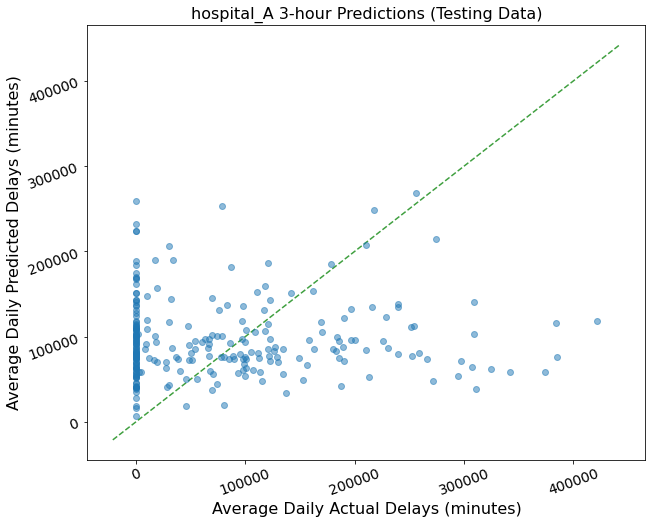

Hospital: hospital_A, Hour: 3, Getting important features...

Hospital: hospital_A, Hour: 10, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


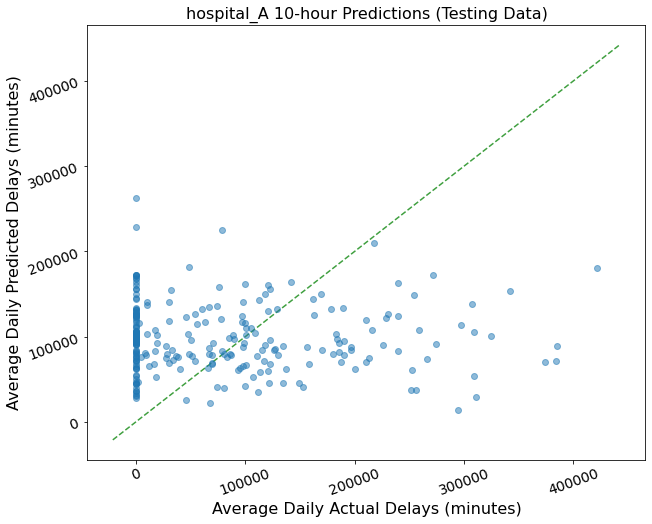

Hospital: hospital_A, Hour: 10, Getting important features...

Hospital: hospital_A, Hour: 24, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


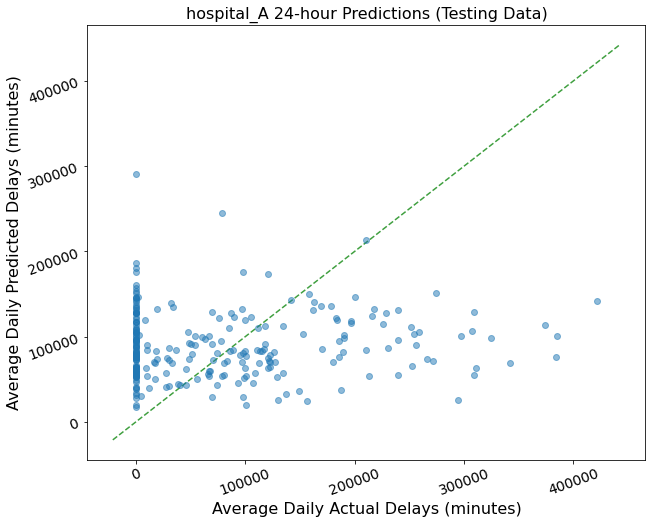

Hospital: hospital_A, Hour: 24, Getting important features...

Hospital: hospital_B, Hour: 3, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


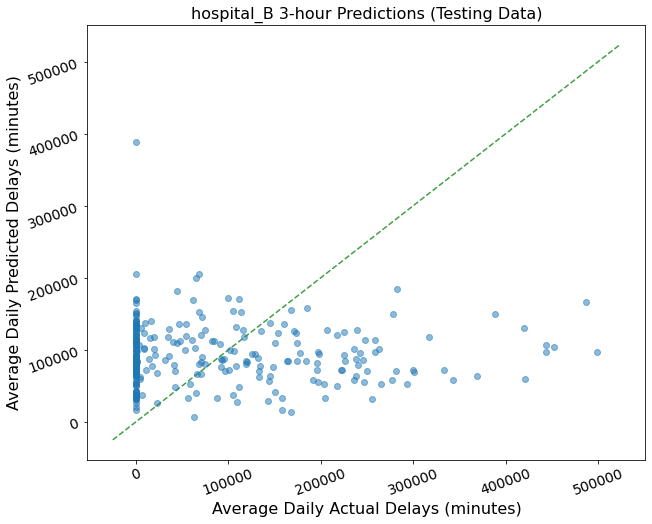

Hospital: hospital_B, Hour: 3, Getting important features...

Hospital: hospital_B, Hour: 10, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


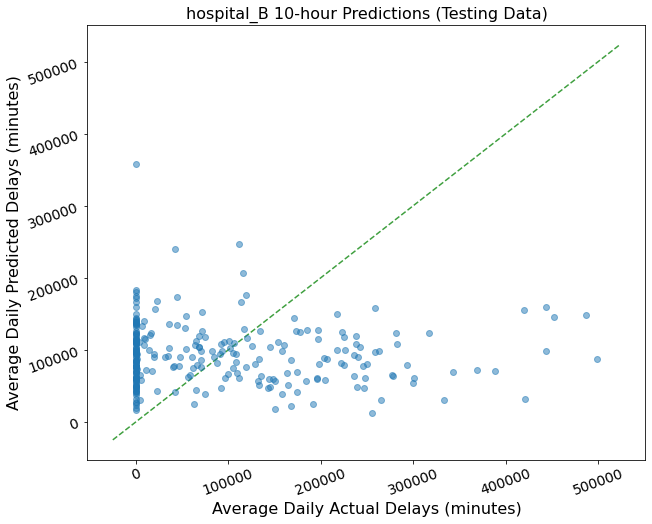

Hospital: hospital_B, Hour: 10, Getting important features...

Hospital: hospital_B, Hour: 24, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


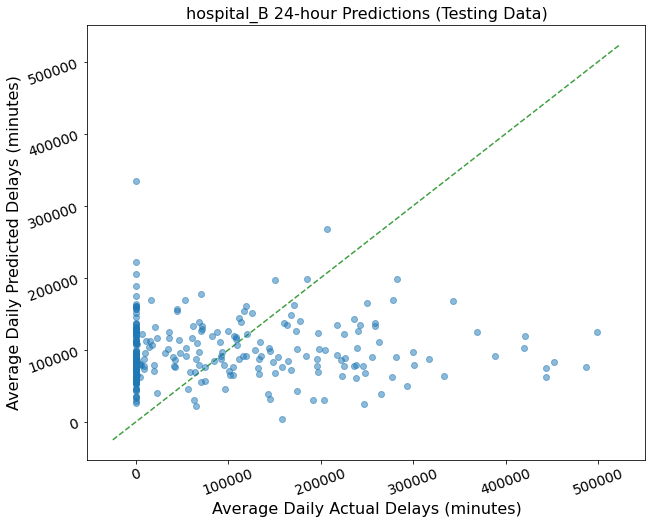

Hospital: hospital_B, Hour: 24, Getting important features...

Hospital: hospital_C, Hour: 3, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


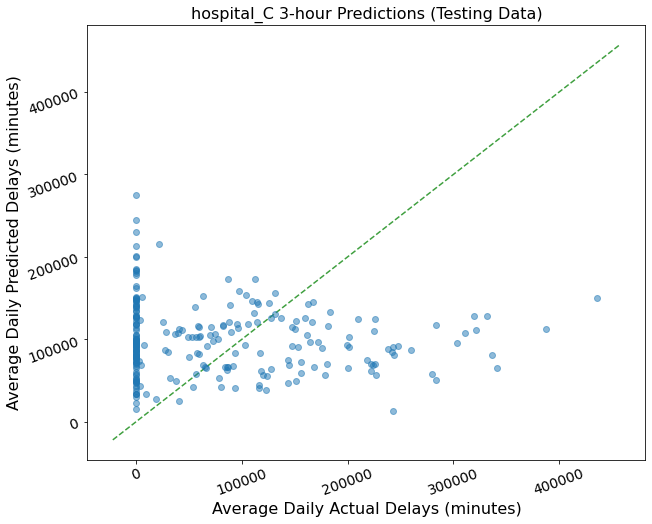

Hospital: hospital_C, Hour: 3, Getting important features...

Hospital: hospital_C, Hour: 10, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


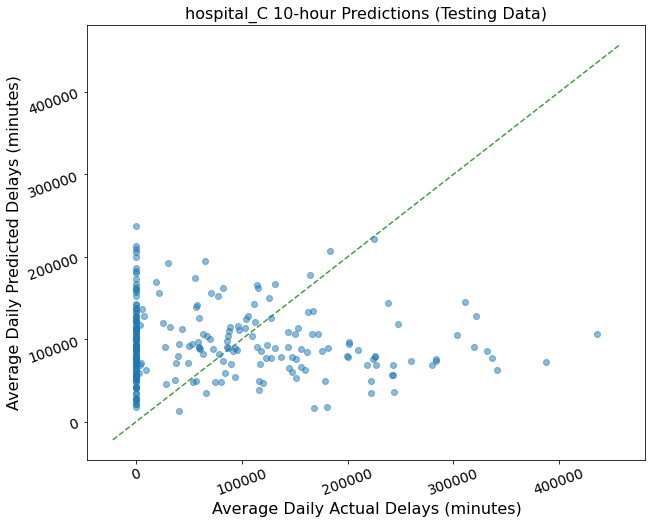

Hospital: hospital_C, Hour: 10, Getting important features...

Hospital: hospital_C, Hour: 24, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


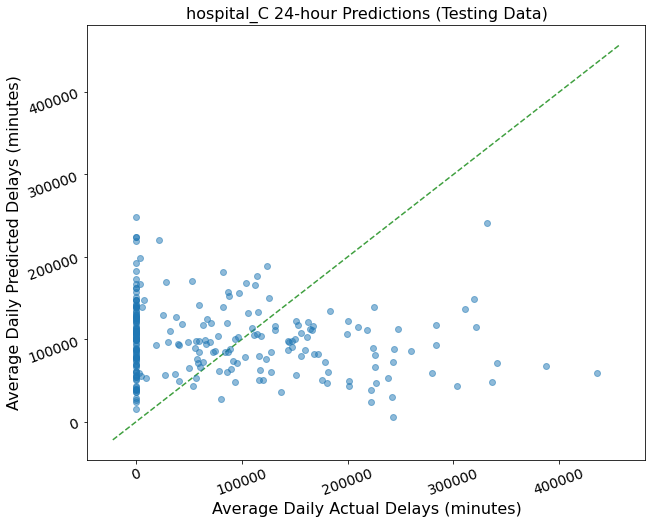

Hospital: hospital_C, Hour: 24, Getting important features...

Hospital: hospital_D, Hour: 3, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


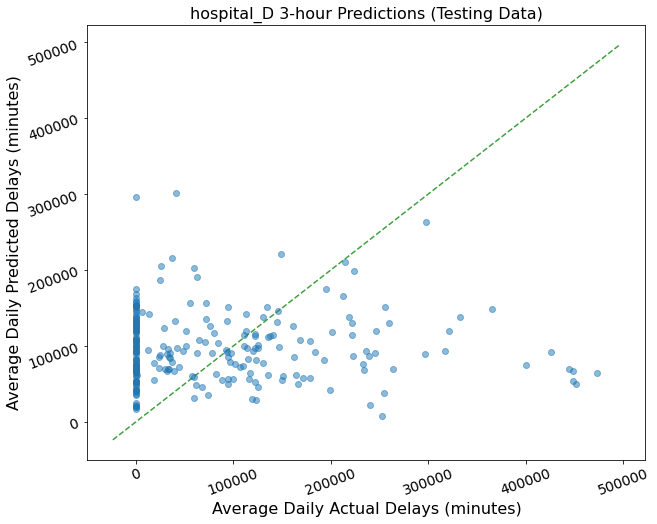

Hospital: hospital_D, Hour: 3, Getting important features...

Hospital: hospital_D, Hour: 10, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


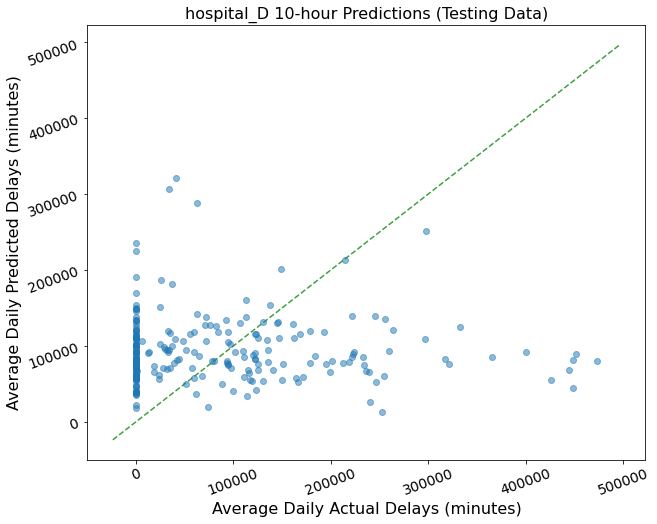

Hospital: hospital_D, Hour: 10, Getting important features...

Hospital: hospital_D, Hour: 24, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


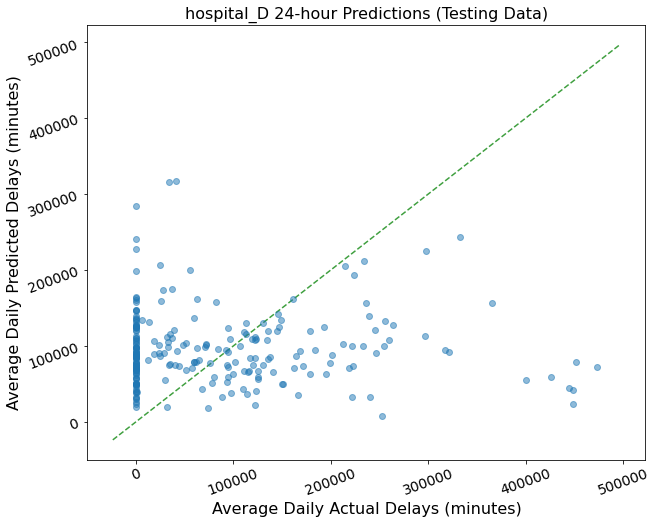

Hospital: hospital_D, Hour: 24, Getting important features...

Hospital: hospital_E, Hour: 3, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


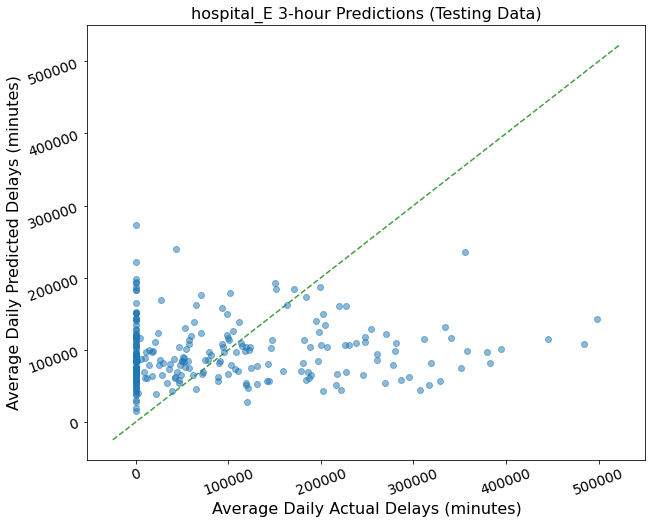

Hospital: hospital_E, Hour: 3, Getting important features...

Hospital: hospital_E, Hour: 10, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


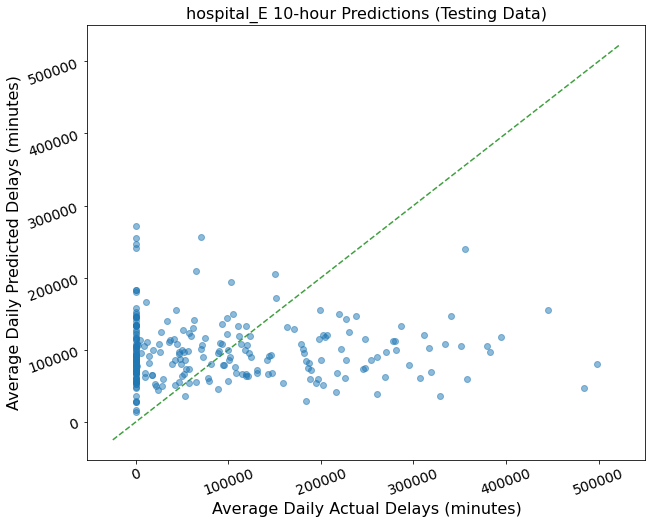

Hospital: hospital_E, Hour: 10, Getting important features...

Hospital: hospital_E, Hour: 24, Starting modelling...
The scatter plot for the daily mean predictions from the testing data:


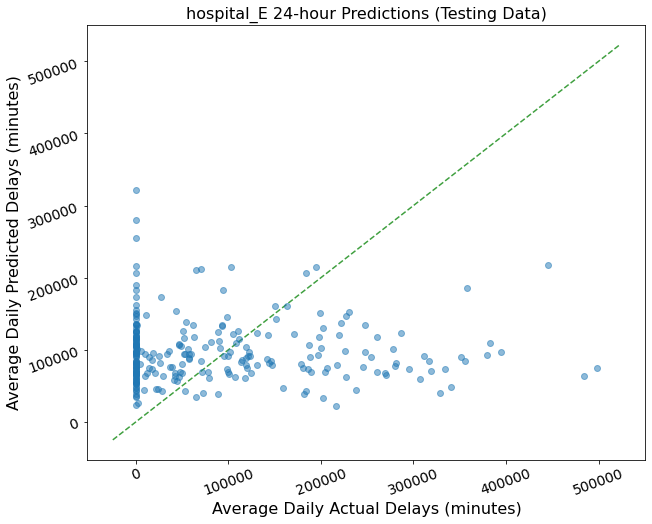

Hospital: hospital_E, Hour: 24, Getting important features...



In [46]:
random_forest_fake_results_df, random_forest_fake_results_dict = loop_random_forest_model(FAKE_ORDINALS, 
                                                                                          FAKE_REALS, 
                                                                                          fake_datasets_dict, 
                                                                                          list_of_fake_hospitals, 
                                                                                          feature_importance=True, 
                                                                                          get_scatter_plots=True)

### The results table for the Random Forest model

The results table shows the predictions for each hospital for the last timestamp in our dataset. More specifically, for the last timestamp in our dataset, if we had predicted 3-hours, 10-hours or 24-hours in advance, these are the results we would have outputted. The results are given as a time interval, which is our predicted value +/- the error calculated for that hospital.

In [48]:
fake_random_forest_results_table = make_handover_times_results_table(random_forest_fake_results_df, coloured_output=False)
df_results = fake_random_forest_results_table
df_results.to_csv('../outputs/random_forest_results_table.csv')

df_results

,Handover Time Range for 3hr (minutes),Handover Time Range for 10hr (minutes),Handover Time Range for 24hr (minutes)
Hospital,,,
hospital_A,0 - 124401,0 - 141729,0 - 120826
hospital_B,45862 - 257596,25385 - 238722,1972 - 210846
hospital_C,0 - 171966,0 - 147963,0 - 195537
hospital_D,0 - 196628,0 - 176486,9666 - 221251
hospital_E,0 - 183431,0 - 179090,0 - 166193


### The feature importance table for the Random Forest model

The importance table summarises the three top features for each prediction for each hospital. This example is using the latest timestamp in our data. The table is showing what the model would have predicted from the situation at the hospital 3 hours ago, 10 hours ago and 24 hours ago. 

In [49]:
fake_random_forest_feature_importance_table = make_feature_importance_table(random_forest_fake_results_dict, list_of_fake_hospitals, keyword_to_english_map)
df_feature_results = fake_random_forest_feature_importance_table
df_feature_results.to_csv('../outputs/random_forest_feature_importance_table.csv')

df_feature_results

3hr-Prediction  \
Hospital   Feature Number                                   
hospital_A 1                              Hour of the Day   
           2                                     Rainfall   
           3                           Missing Crew Skill   
hospital_B 1                 Arrivals at Hospitals Nearby   
           2                          Minimum Temperature   
           3                                     Rainfall   
hospital_C 1               Number of Ambulance Departures   
           2                                     Rainfall   
           3                 Arrivals at Hospitals Nearby   
hospital_D 1                                     Rainfall   
           2                                  Day of Week   
           3                 Arrivals at Hospitals Nearby   
hospital_E 1                 Arrivals at Hospitals Nearby   
           2                                     Rainfall   
           3                                 Patient Flow   

                                                  10hr-Prediction  \
Hospital   Feature Number                                           
hospital_A 1                         Arrivals at Hospitals Nearby   
           2                                      Hour of the Day   
           3               Average Handover Delay in Past 6 Hours   
hospital_B 1                         Number of Ambulance Arrivals   
           2                                             Rainfall   
           3                                  Minimum Temperature   
hospital_C 1                         Arrivals at Hospitals Nearby   
           2                                             Rainfall   
           3                                         Patient Flow   
hospital_D 1                                          Day of Week   
           2                                             Rainfall   
           3               Average Handover Delay in Past 6 Hours   
hospital_E 1               Average Handover Delay in Past 6 Hours   
           2                         Arrivals at Hospitals Nearby   
           3                                   Missing Crew Skill   

                                                  24hr-Prediction  
Hospital   Feature Number                                          
hospital_A 1                                         Patient Flow  
           2                         Arrivals at Hospitals Nearby  
           3                                          Day of Week  
hospital_B 1                                                Month  
           2                                  Maximum Temperature  
           3                                         Patient Flow  
hospital_C 1                                             Rainfall  
           2                       Number of Ambulance Departures  
           3               Average Handover Delay in Past 6 Hours  
hospital_D 1                         Arrivals at Hospitals Nearby  
           2               Average Handover Delay in Past 6 Hours  
           3                                         Patient Flow  
hospital_E 1               Average Handover Delay in Past 6 Hours  
           2                       Number of Ambulance Departures  
           3                           Number of Priority 1 Cases